## Load libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter
from tqdm import tqdm

In [2]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import sympy

# Basal FIR

## Load data

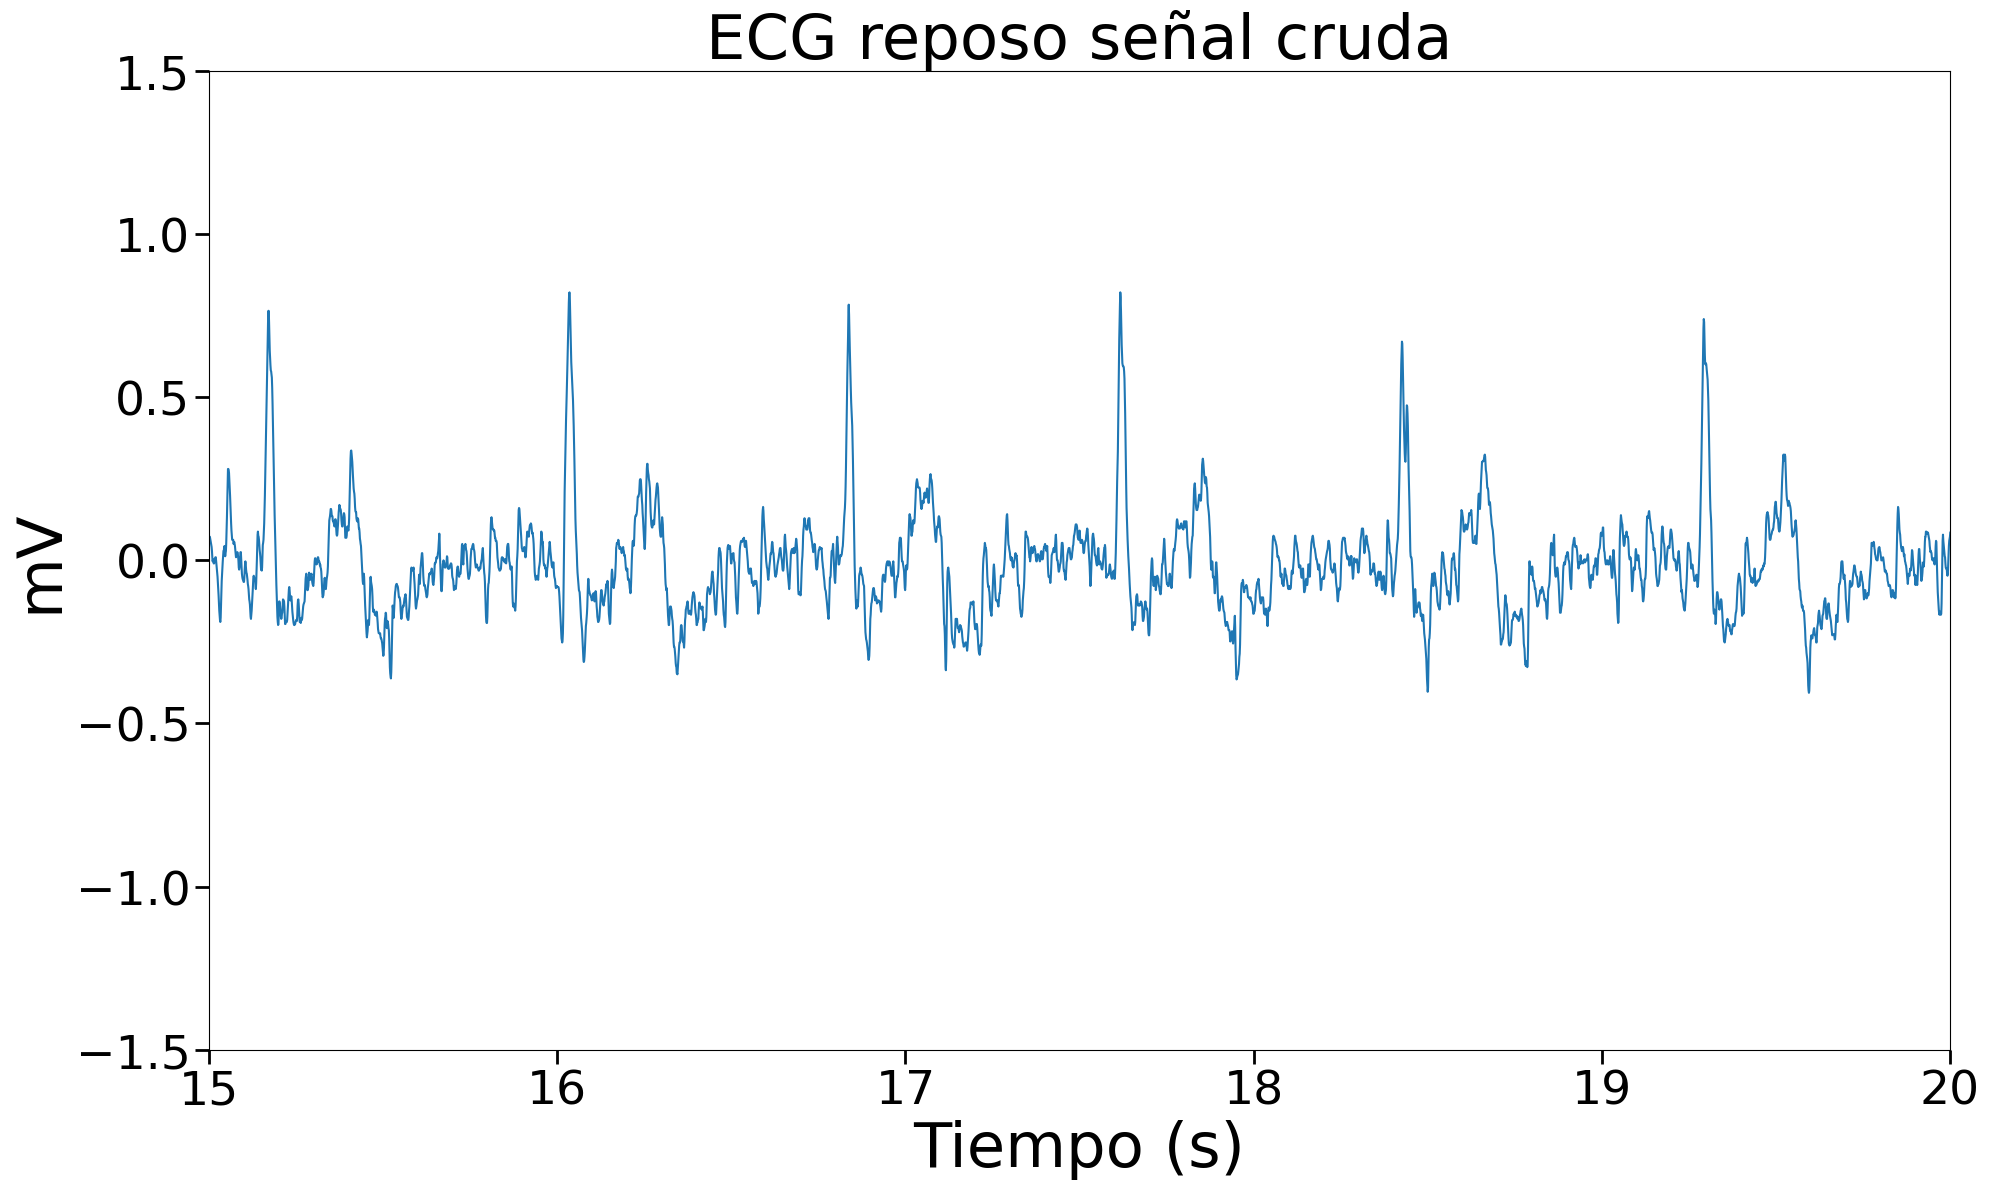

In [53]:
data=np.loadtxt("./../Laboratorio 4/ecg_raw_data/reposo/opensignals_98D341FD4F0D_2024-04-19_12-34-17.txt",skiprows=3)
data_mV = data[:,5]/1024 *3.223 - 3.223/2 #De acuerdo a la cuantización de 3.223 mV a 1024 bits del manual de Bitalino
time = np.arange(len(data_mV))/1000 
plt.figure(figsize=(20,12))

plt.plot(time,data_mV)

plt.ylim(-1.5, 1.5)
plt.xlim(15, 20)
plt.tick_params(axis='both', which='major', labelsize=34, width=2, length=10)
plt.xlabel('Tiempo (s)', fontsize=45)
plt.ylabel('mV', fontsize=45)
plt.title('ECG reposo señal cruda', fontsize=45)
plt.tight_layout()

plt.savefig("plots/ecg-reposo-cruda.png")


## DFT de N puntos

(1024,)


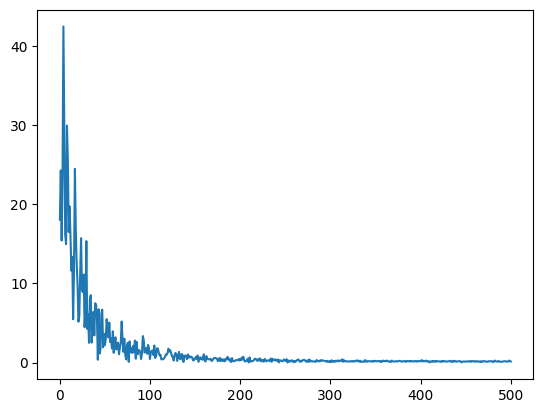

In [54]:
#Tomamos solo 5 segundos de la señal
x=data_mV[15000:20000]

#transformada de fourier FFT
Fs = 1000 #frecuencia de muestreo
N = 1024
X = np.fft.fft(x,N)
print(X.shape)

X = X[0:(N//2)]

#magnitud
Xm = np.abs(X)
Xm = np.round(Xm,3)

#frecuencias
F = np.linspace(0, Fs/2, N//2)

#eje de tiempo en seg
n=np.arange(len(x))
t = n/Fs

plt.plot(F,Xm)
#plt.xlim(0, 10)


## Diseñar el filtro FIR pasa bajos

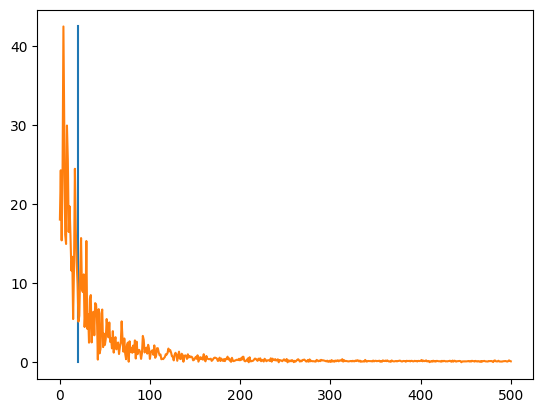

In [55]:
#longitud de la ventana
M = 37
#frecuencia de corte en Hz
Fc = 20
#Frecuencia de muestreo
Fs = 1000 #frecuencia de muestreo

#Frecuencia de corte en radianes
wc = 2*np.pi*Fc/Fs

# filtro fir
w = firwin(numtaps=M, cutoff=Fc, window='hamming', fs=Fs)
w = np.round(w,3)

nm = np.arange(M)
W = np.fft.fft(w,N)
W = np.round(W[0:N//2],3)

#magnitud
Wm = np.abs(W)
Rx = Fc*np.ones([N//2])
Ry = np.linspace(0,1,N//2)

Ry = np.linspace(0,np.max(Xm),N//2) #el eje y

plt.plot(Rx,Ry)
plt.plot(F,Xm)

## Aplicación del filtro FIR a la entrada x

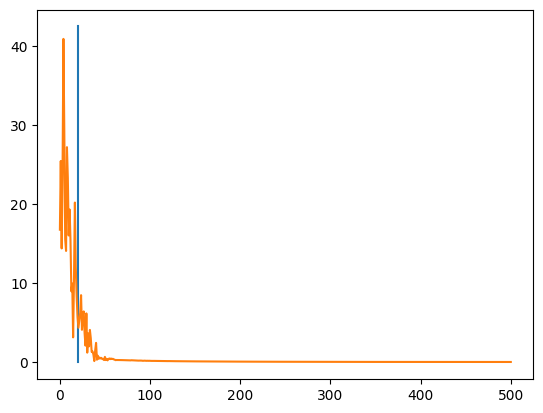

In [56]:
y = lfilter(w, np.array(1),x)
Y = np.fft.fft(y,N)
Y = np.round(Y[0:N//2],3)

Ym = np.abs(Y)

Ry = np.linspace(0,np.max(Xm),N//2) #el eje y

plt.plot(Rx,Ry)
plt.plot(F,Ym)


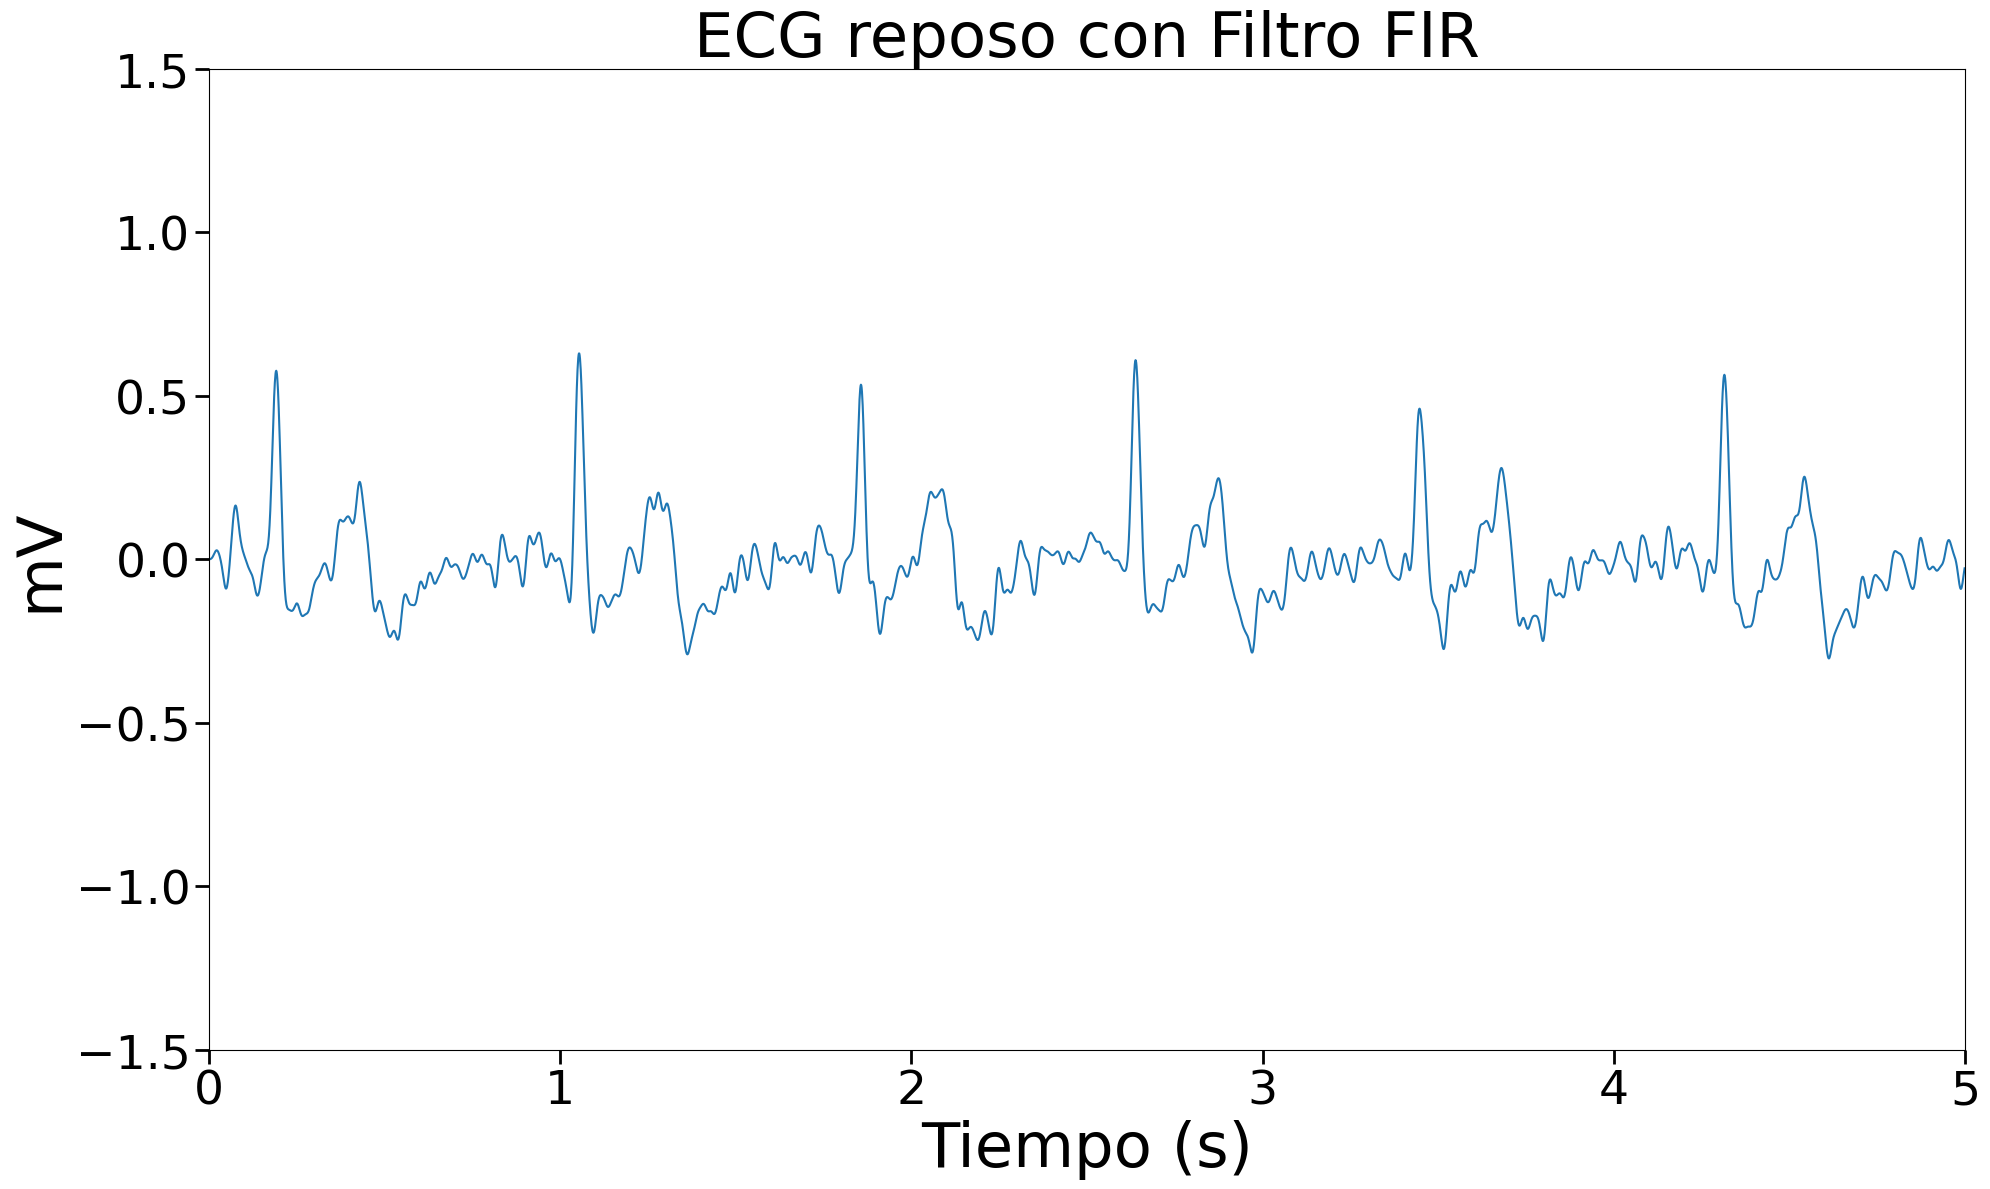

In [57]:
plt.figure(figsize=(20,12))

plt.plot(t,y)

plt.ylim(-1.5, 1.5)
plt.xlim(0, 5)
plt.tick_params(axis='both', which='major', labelsize=34, width=2, length=10)
plt.xlabel('Tiempo (s)', fontsize=45)
plt.ylabel('mV', fontsize=45)
plt.title('ECG reposo con Filtro FIR', fontsize=45)
plt.tight_layout()

plt.savefig("plots/ecg-reposo-FIR.png")


# Basal IIR


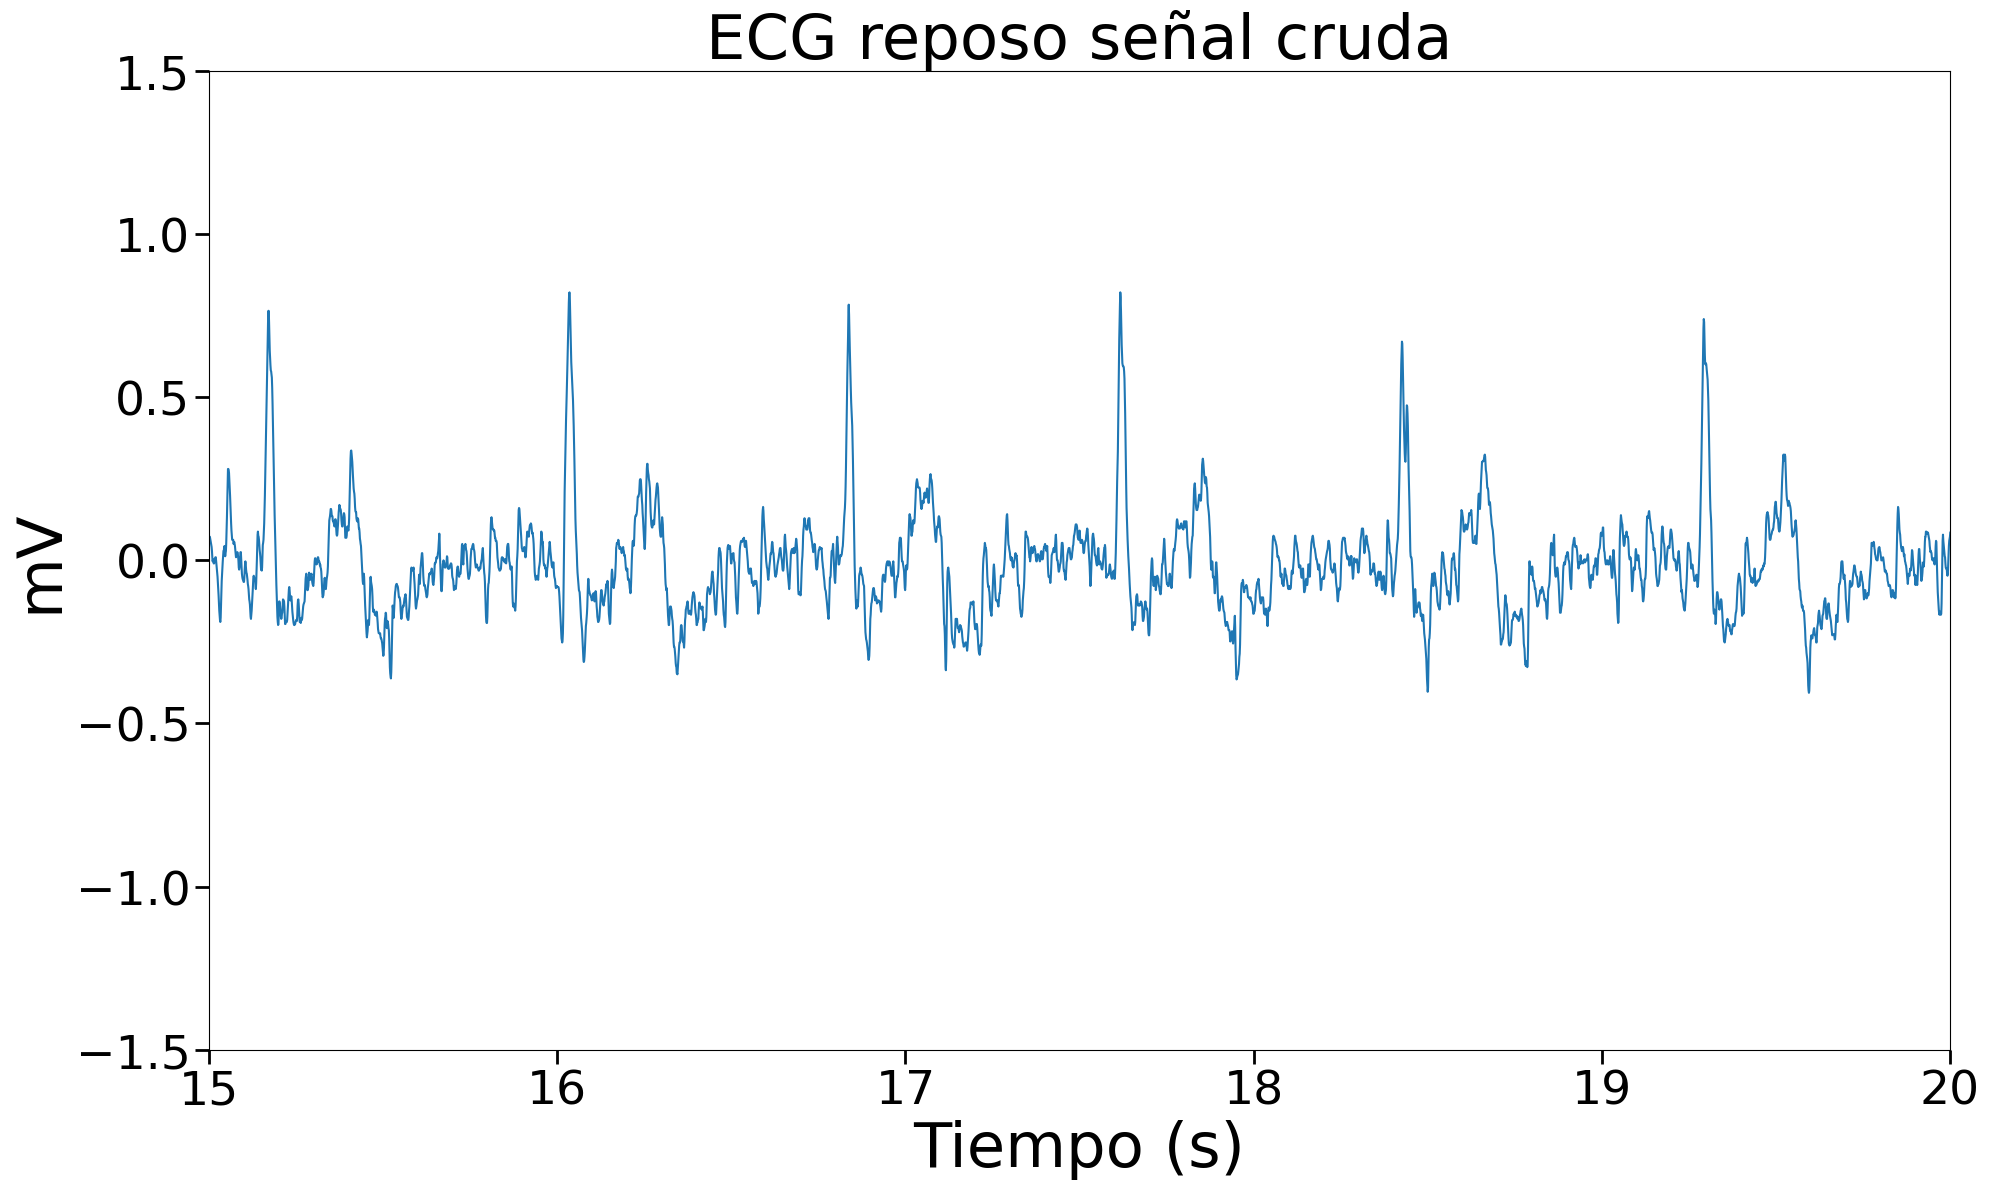

In [14]:
data=np.loadtxt("./../Laboratorio 4/ecg_raw_data/reposo/opensignals_98D341FD4F0D_2024-04-19_12-34-17.txt",skiprows=3)
data_mV = data[:,5]/1024 *3.223 - 3.223/2 #De acuerdo a la cuantización de 3.223 mV a 1024 bits del manual de Bitalino
time = np.arange(len(data_mV))/1000 
plt.figure(figsize=(20,12))

plt.plot(time,data_mV)

plt.ylim(-1.5, 1.5)
plt.xlim(15, 20)
plt.tick_params(axis='both', which='major', labelsize=34, width=2, length=10)
plt.xlabel('Tiempo (s)', fontsize=45)
plt.ylabel('mV', fontsize=45)
plt.title('ECG reposo señal cruda', fontsize=45)
plt.tight_layout()

#Tomamos solo 5 segundos de la señal
x=data_mV[15000:20000]



## Diseño del filtro pasa bajo 

In [16]:
wp=2*np.pi*30
ws=2*np.pi*100

N_ord, Wc= signal.buttord(wp, ws, gpass=3, gstop=40, analog=True) #gpass=loss in passband edge frecuencies, gstop= attenuation in stopband edge frecuencies 
fc = np.round(Wc/(2*np.pi) ,2) 

print(f"Orden del filtro: {N_ord}")
print(f"Frecuencia de corte calculada: {fc} hz")


Orden del filtro: 4
Frecuencia de corte calculada: 30.02 hz


In [17]:
# Funcion de transferencia del filtro pasa bajo analogico
b,a = signal.butter(N_ord, Wc, 'lowpass', True, 'ba')

#np.set_printoptions(precision=3)
b,a

(array([1.26542297e+09]),
 array([1.00000000e+00, 4.92855114e+02, 1.21453082e+05, 1.75322286e+07,
        1.26542297e+09]))

Text(0, 0.5, 'Magnitud (db)')

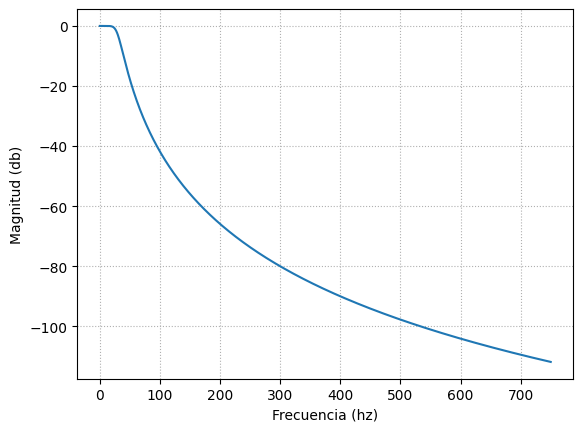

In [18]:
# Respuesta en frecuencia del filtro analogico
Fmax=750
F_freqs = np.linspace(0,Fmax,1000)
W_freqs = 2*np.pi*F_freqs  #Angular frecuences

W_freqs, H = signal.freqs(b,a,W_freqs)
Hm=np.abs(H)
plt.plot(F_freqs, 20 * np.log10(Hm))
plt.grid(linestyle=":")
plt.xlabel("Frecuencia (hz)")
plt.ylabel("Magnitud (db)")

Text(0, 0.5, 'Magnitud (db)')

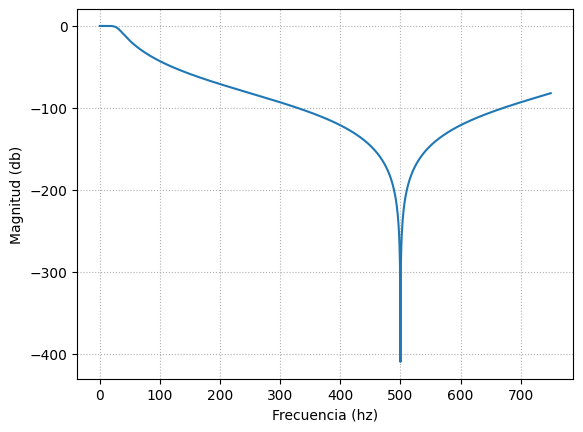

In [19]:
bd, ad = signal.bilinear(b,a,Fs)

Wz, Hd = signal.freqz(bd, ad, W_freqs/Fs)

Hdm = np.abs(Hd)
plt.plot(F_freqs, 20 * np.log10(Hdm))
plt.grid(linestyle=":")
plt.xlabel("Frecuencia (hz)")
plt.ylabel("Magnitud (db)")

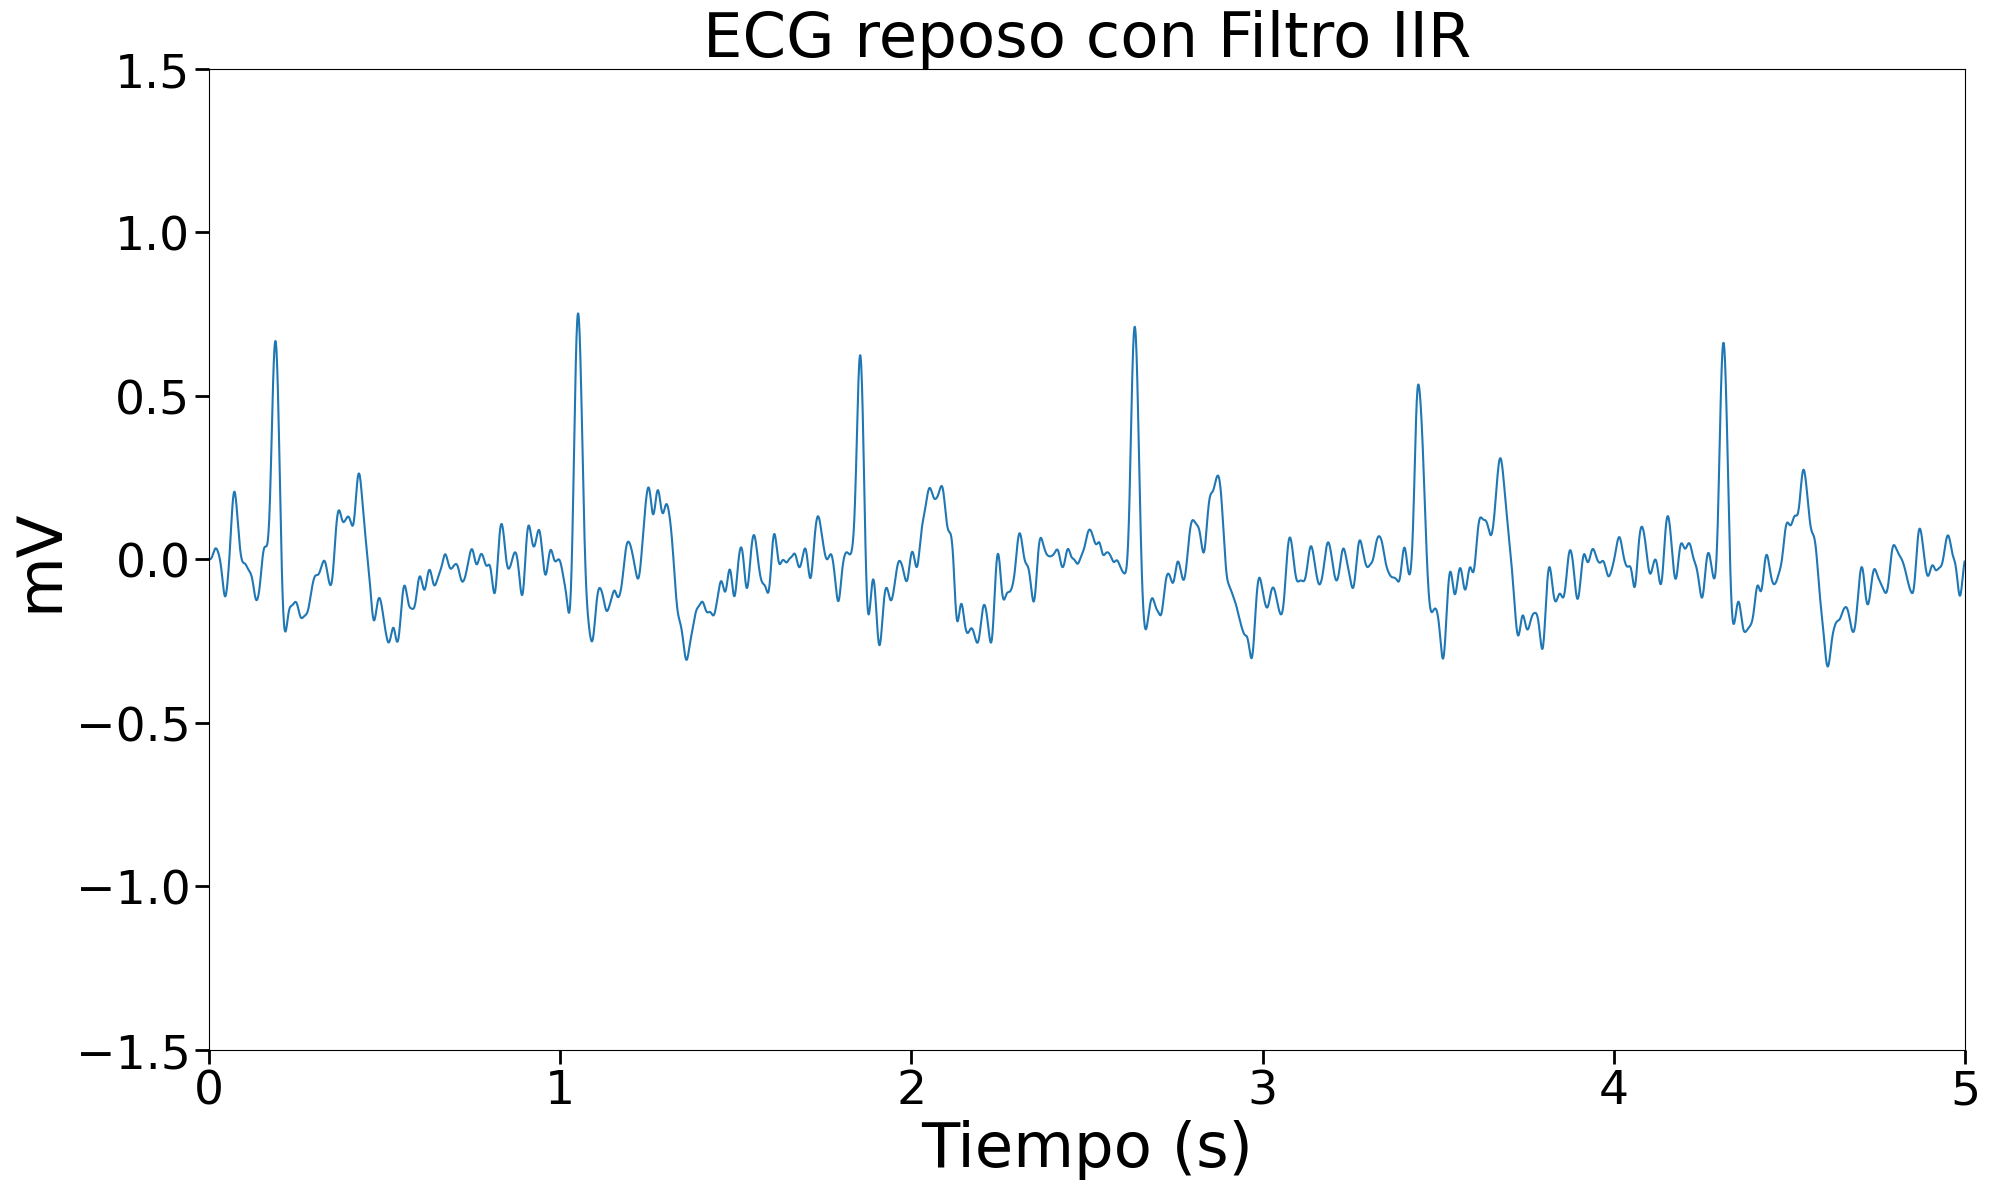

In [20]:
y = signal.lfilter(bd,ad, x)

#eje de tiempo en seg
Fs=1000 #frecuencia de muestreo
n=np.arange(len(x))
t = n/Fs

plt.figure(figsize=(20,12))

plt.plot(t,y)

plt.ylim(-1.5, 1.5)
plt.xlim(0, 5)
plt.tick_params(axis='both', which='major', labelsize=34, width=2, length=10)
plt.xlabel('Tiempo (s)', fontsize=45)
plt.ylabel('mV', fontsize=45)
plt.title('ECG reposo con Filtro IIR', fontsize=45)
plt.tight_layout()

plt.savefig("plots/ecg-reposo-IIR.png")



# Respiración FIR

## Load data

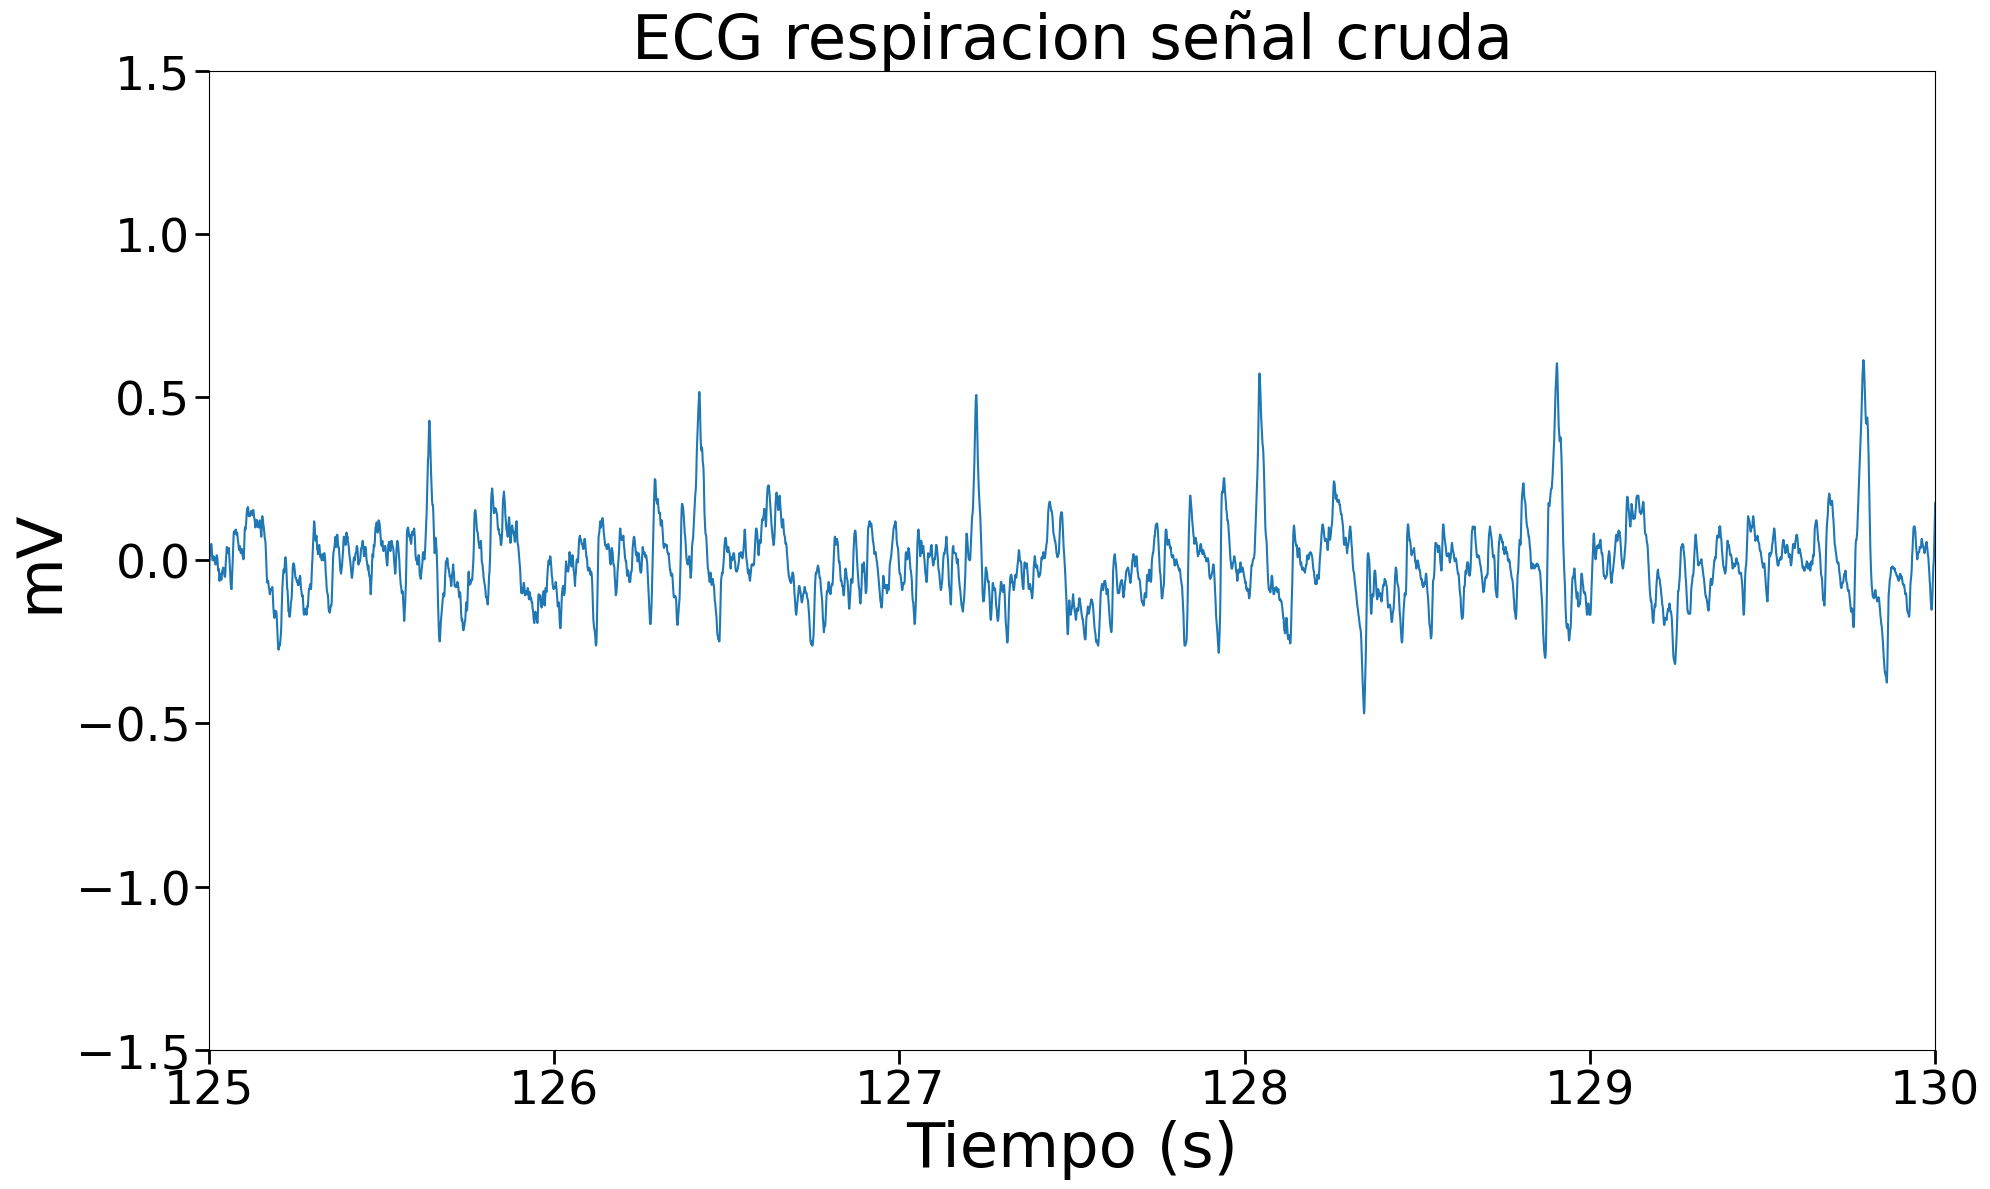

In [63]:
data=np.loadtxt("./../Laboratorio 4/ecg_raw_data/reposo/opensignals_98D341FD4F0D_2024-04-19_12-34-17.txt",skiprows=3)
data_mV = data[:,5]/1024 *3.223 - 3.223/2 #De acuerdo a la cuantización de 3.223 mV a 1024 bits del manual de Bitalino
time = np.arange(len(data_mV))/1000 
plt.figure(figsize=(20,12))

plt.plot(time,data_mV)

plt.ylim(-1.5, 1.5)
plt.xlim(125, 130)
plt.tick_params(axis='both', which='major', labelsize=34, width=2, length=10)
plt.xlabel('Tiempo (s)', fontsize=45)
plt.ylabel('mV', fontsize=45)
plt.title('ECG respiracion señal cruda', fontsize=45)
plt.tight_layout()

plt.savefig("plots/ecg-respiracion-cruda.png")


## DFT de N puntos

(1024,)


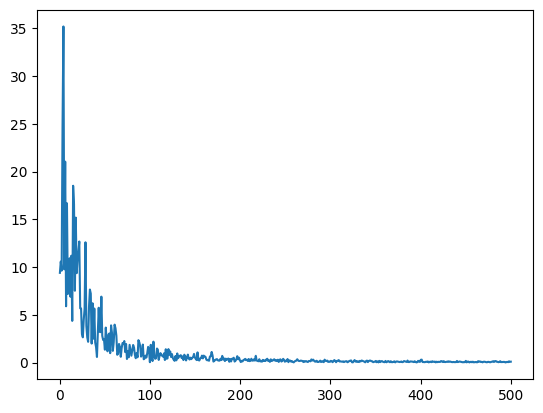

In [64]:
#Tomamos solo 5 segundos de la señal
x=data_mV[125000:130000]

#transformada de fourier FFT
Fs = 1000 #frecuencia de muestreo
N = 1024
X = np.fft.fft(x,N)
print(X.shape)

X = X[0:(N//2)]

#magnitud
Xm = np.abs(X)
Xm = np.round(Xm,3)

#frecuencias
F = np.linspace(0, Fs/2, N//2)

#eje de tiempo en seg
n=np.arange(len(x))
t = n/Fs

plt.plot(F,Xm)
#plt.xlim(0, 10)


## Diseñar el filtro FIR pasa bajos

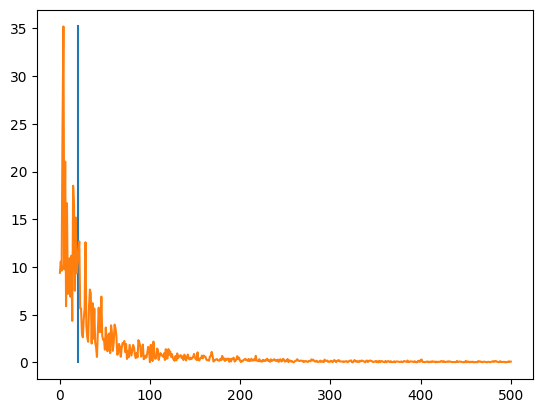

In [65]:
#longitud de la ventana
M = 37
#frecuencia de corte en Hz
Fc = 20
#Frecuencia de muestreo
Fs = 1000 #frecuencia de muestreo

#Frecuencia de corte en radianes
wc = 2*np.pi*Fc/Fs

# filtro fir
w = firwin(numtaps=M, cutoff=Fc, window='hamming', fs=Fs)
w = np.round(w,3)

nm = np.arange(M)
W = np.fft.fft(w,N)
W = np.round(W[0:N//2],3)

#magnitud
Wm = np.abs(W)
Rx = Fc*np.ones([N//2])
Ry = np.linspace(0,1,N//2)

Ry = np.linspace(0,np.max(Xm),N//2) #el eje y

plt.plot(Rx,Ry)
plt.plot(F,Xm)

## Aplicación del filtro FIR a la entrada x

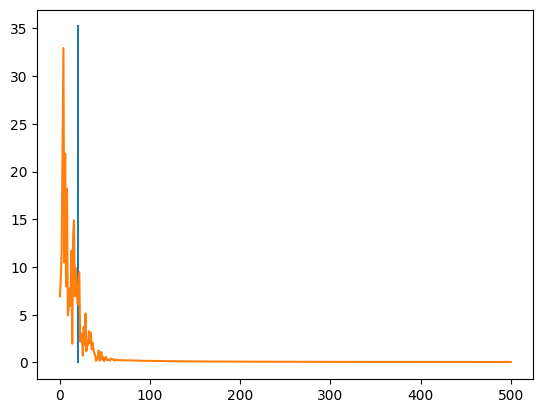

In [66]:
y = lfilter(w, np.array(1),x)
Y = np.fft.fft(y,N)
Y = np.round(Y[0:N//2],3)

Ym = np.abs(Y)

Ry = np.linspace(0,np.max(Xm),N//2) #el eje y

plt.plot(Rx,Ry)
plt.plot(F,Ym)


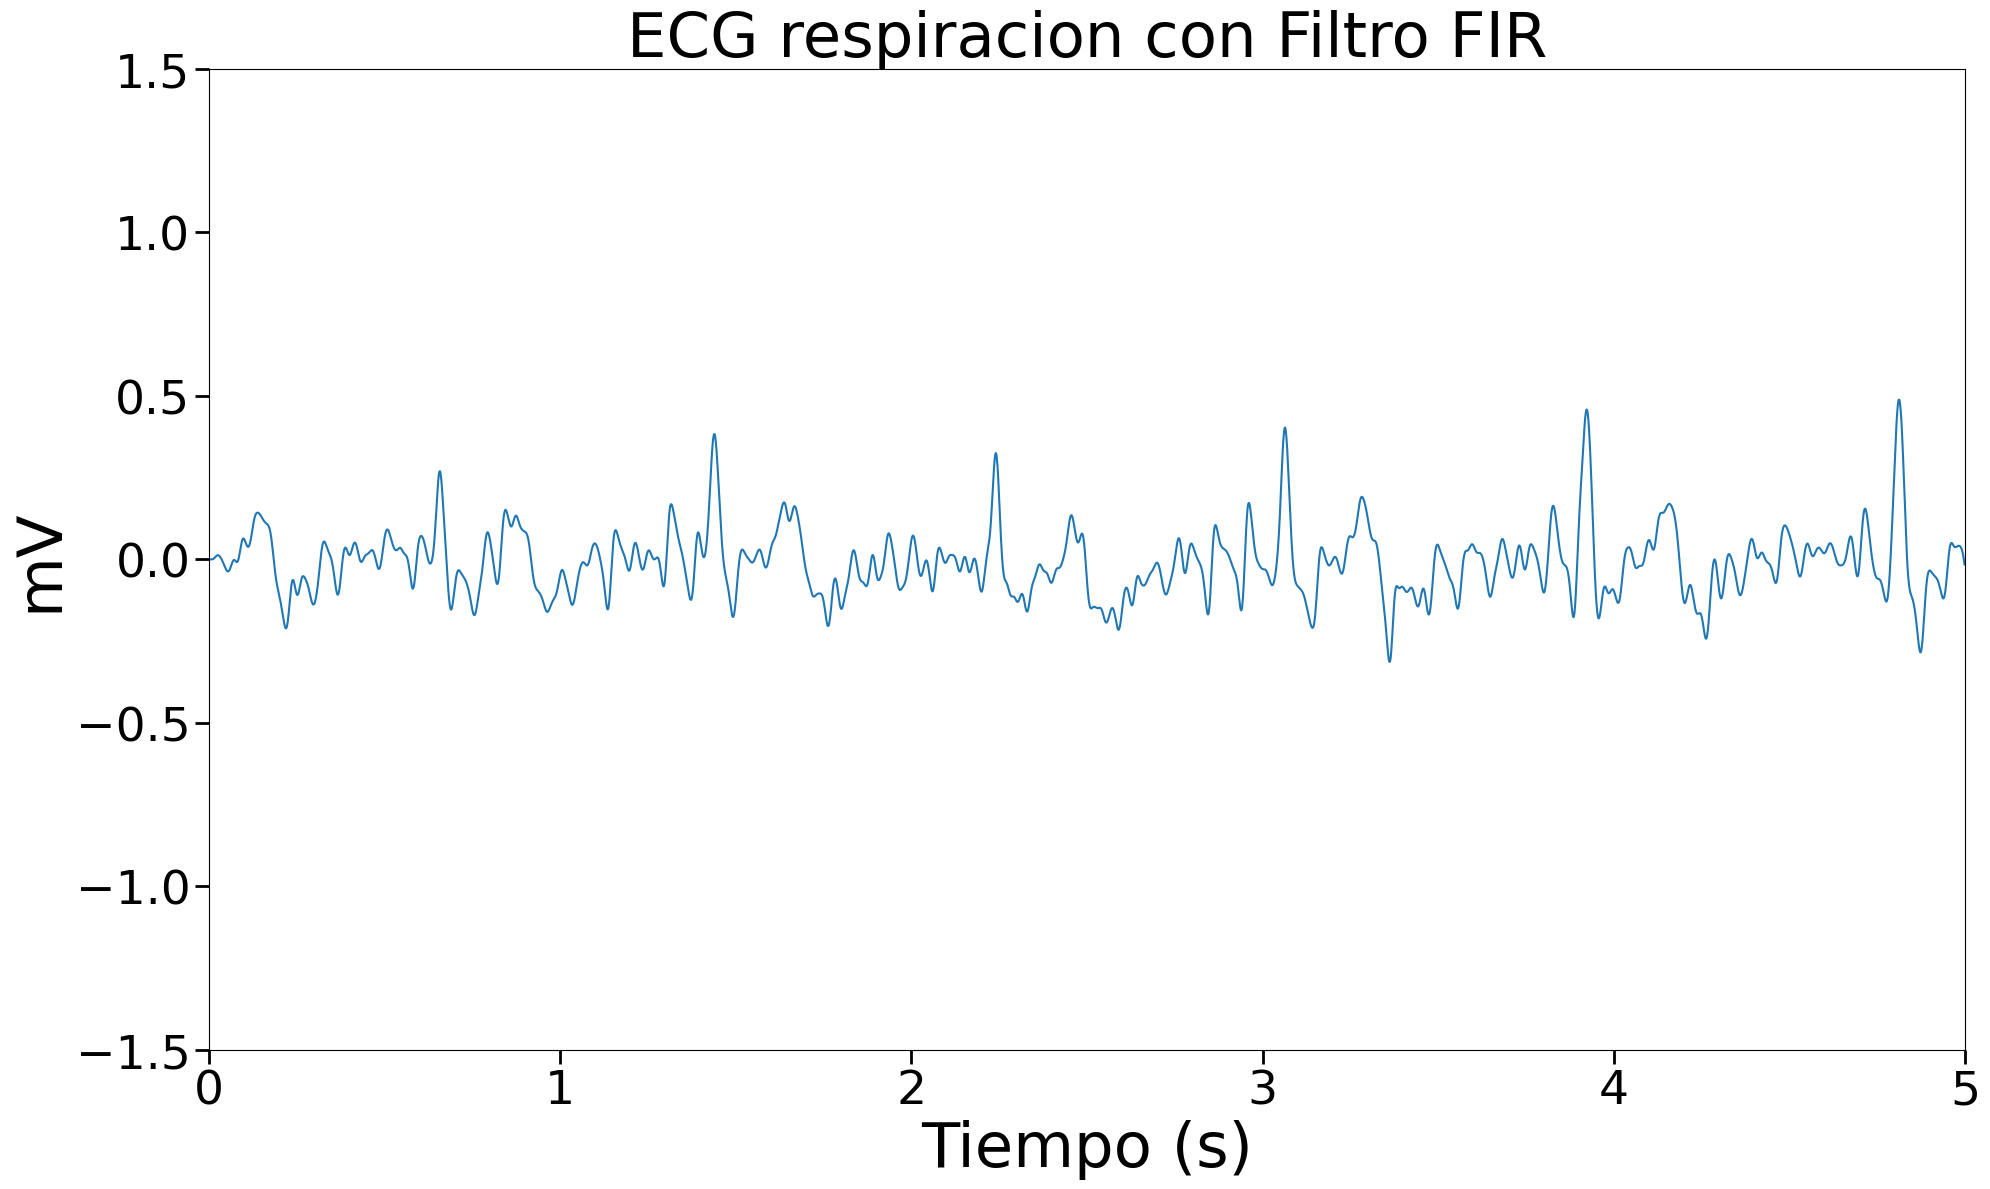

In [67]:
plt.figure(figsize=(20,12))

plt.plot(t,y)

plt.ylim(-1.5, 1.5)
plt.xlim(0, 5)
plt.tick_params(axis='both', which='major', labelsize=34, width=2, length=10)
plt.xlabel('Tiempo (s)', fontsize=45)
plt.ylabel('mV', fontsize=45)
plt.title('ECG respiracion con Filtro FIR', fontsize=45)
plt.tight_layout()

plt.savefig("plots/ecg-respiracion-FIR.png")


# Respiración IIR

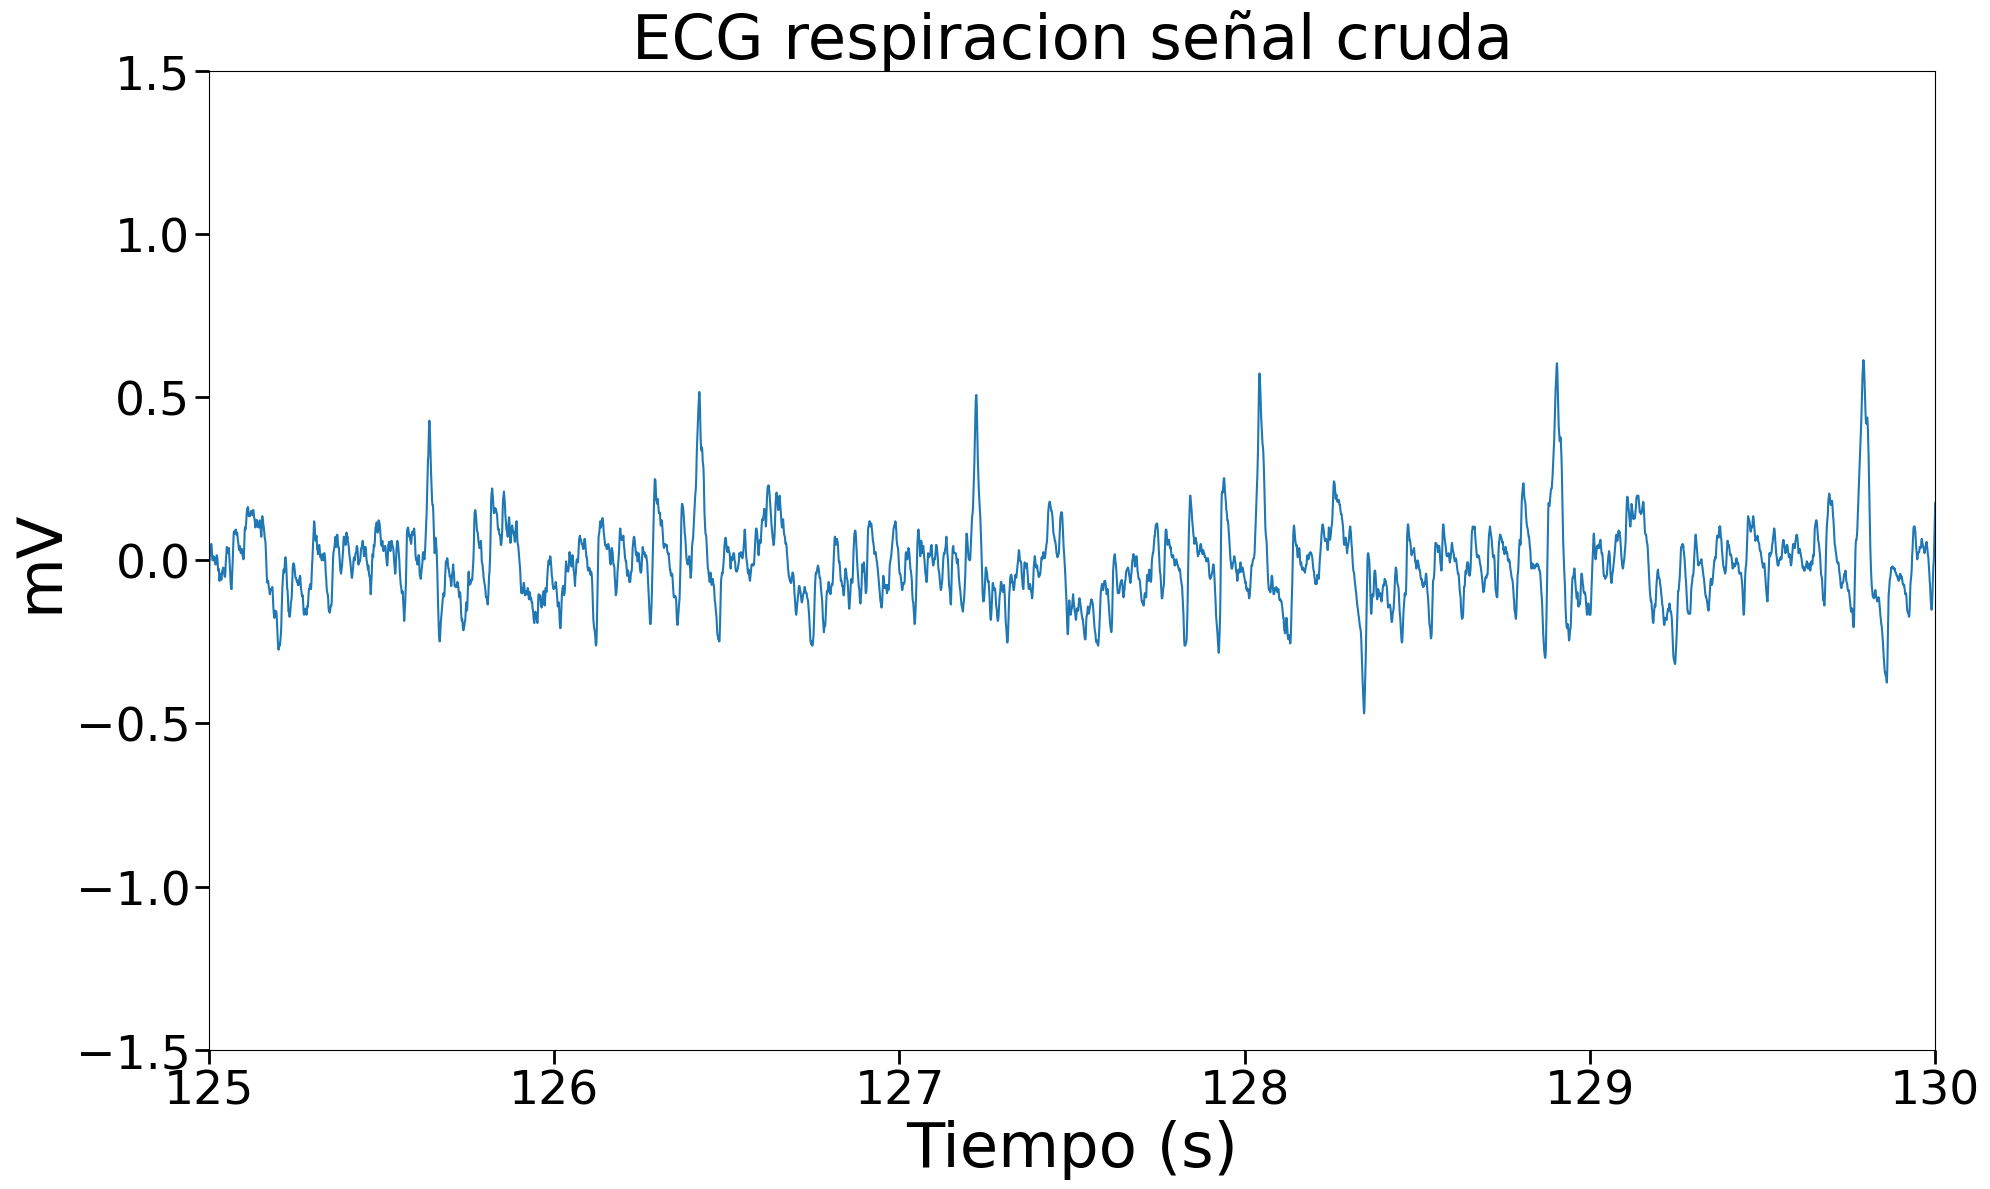

In [21]:
data=np.loadtxt("./../Laboratorio 4/ecg_raw_data/reposo/opensignals_98D341FD4F0D_2024-04-19_12-34-17.txt",skiprows=3)
data_mV = data[:,5]/1024 *3.223 - 3.223/2 #De acuerdo a la cuantización de 3.223 mV a 1024 bits del manual de Bitalino
time = np.arange(len(data_mV))/1000 
plt.figure(figsize=(20,12))

plt.plot(time,data_mV)

plt.ylim(-1.5, 1.5)
plt.xlim(125, 130)
plt.tick_params(axis='both', which='major', labelsize=34, width=2, length=10)
plt.xlabel('Tiempo (s)', fontsize=45)
plt.ylabel('mV', fontsize=45)
plt.title('ECG respiracion señal cruda', fontsize=45)
plt.tight_layout()


#Tomamos solo 5 segundos de la señal
x=data_mV[125000:130000]



## Diseño del filtro pasa bajo 

In [22]:
wp=2*np.pi*30
ws=2*np.pi*100

N_ord, Wc= signal.buttord(wp, ws, gpass=3, gstop=40, analog=True) #gpass=loss in passband edge frecuencies, gstop= attenuation in stopband edge frecuencies 
fc = np.round(Wc/(2*np.pi) ,2) 

print(f"Orden del filtro: {N_ord}")
print(f"Frecuencia de corte calculada: {fc} hz")


Orden del filtro: 4
Frecuencia de corte calculada: 30.02 hz


In [23]:
# Funcion de transferencia del filtro pasa bajo analogico
b,a = signal.butter(N_ord, Wc, 'lowpass', True, 'ba')

#np.set_printoptions(precision=3)
b,a

(array([1.26542297e+09]),
 array([1.00000000e+00, 4.92855114e+02, 1.21453082e+05, 1.75322286e+07,
        1.26542297e+09]))

Text(0, 0.5, 'Magnitud (db)')

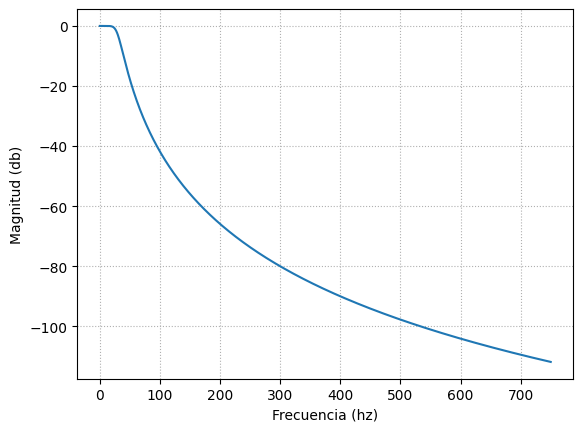

In [24]:
# Respuesta en frecuencia del filtro analogico
Fmax=750
F_freqs = np.linspace(0,Fmax,1000)
W_freqs = 2*np.pi*F_freqs  #Angular frecuences

W_freqs, H = signal.freqs(b,a,W_freqs)
Hm=np.abs(H)
plt.plot(F_freqs, 20 * np.log10(Hm))
plt.grid(linestyle=":")
plt.xlabel("Frecuencia (hz)")
plt.ylabel("Magnitud (db)")

Text(0, 0.5, 'Magnitud (db)')

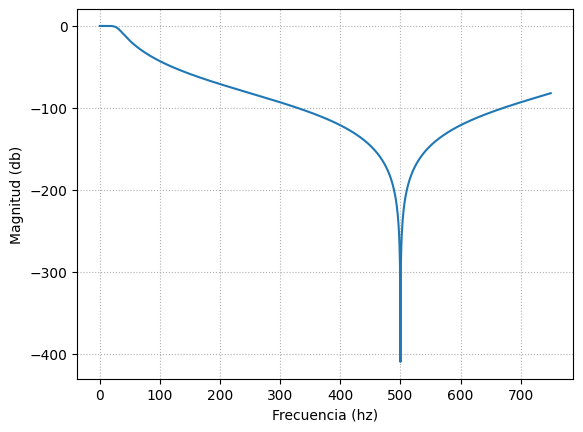

In [25]:
Fs = 1000

bd, ad = signal.bilinear(b,a,Fs)

Wz, Hd = signal.freqz(bd, ad, W_freqs/Fs)

Hdm = np.abs(Hd)
plt.plot(F_freqs, 20 * np.log10(Hdm))
plt.grid(linestyle=":")
plt.xlabel("Frecuencia (hz)")
plt.ylabel("Magnitud (db)")

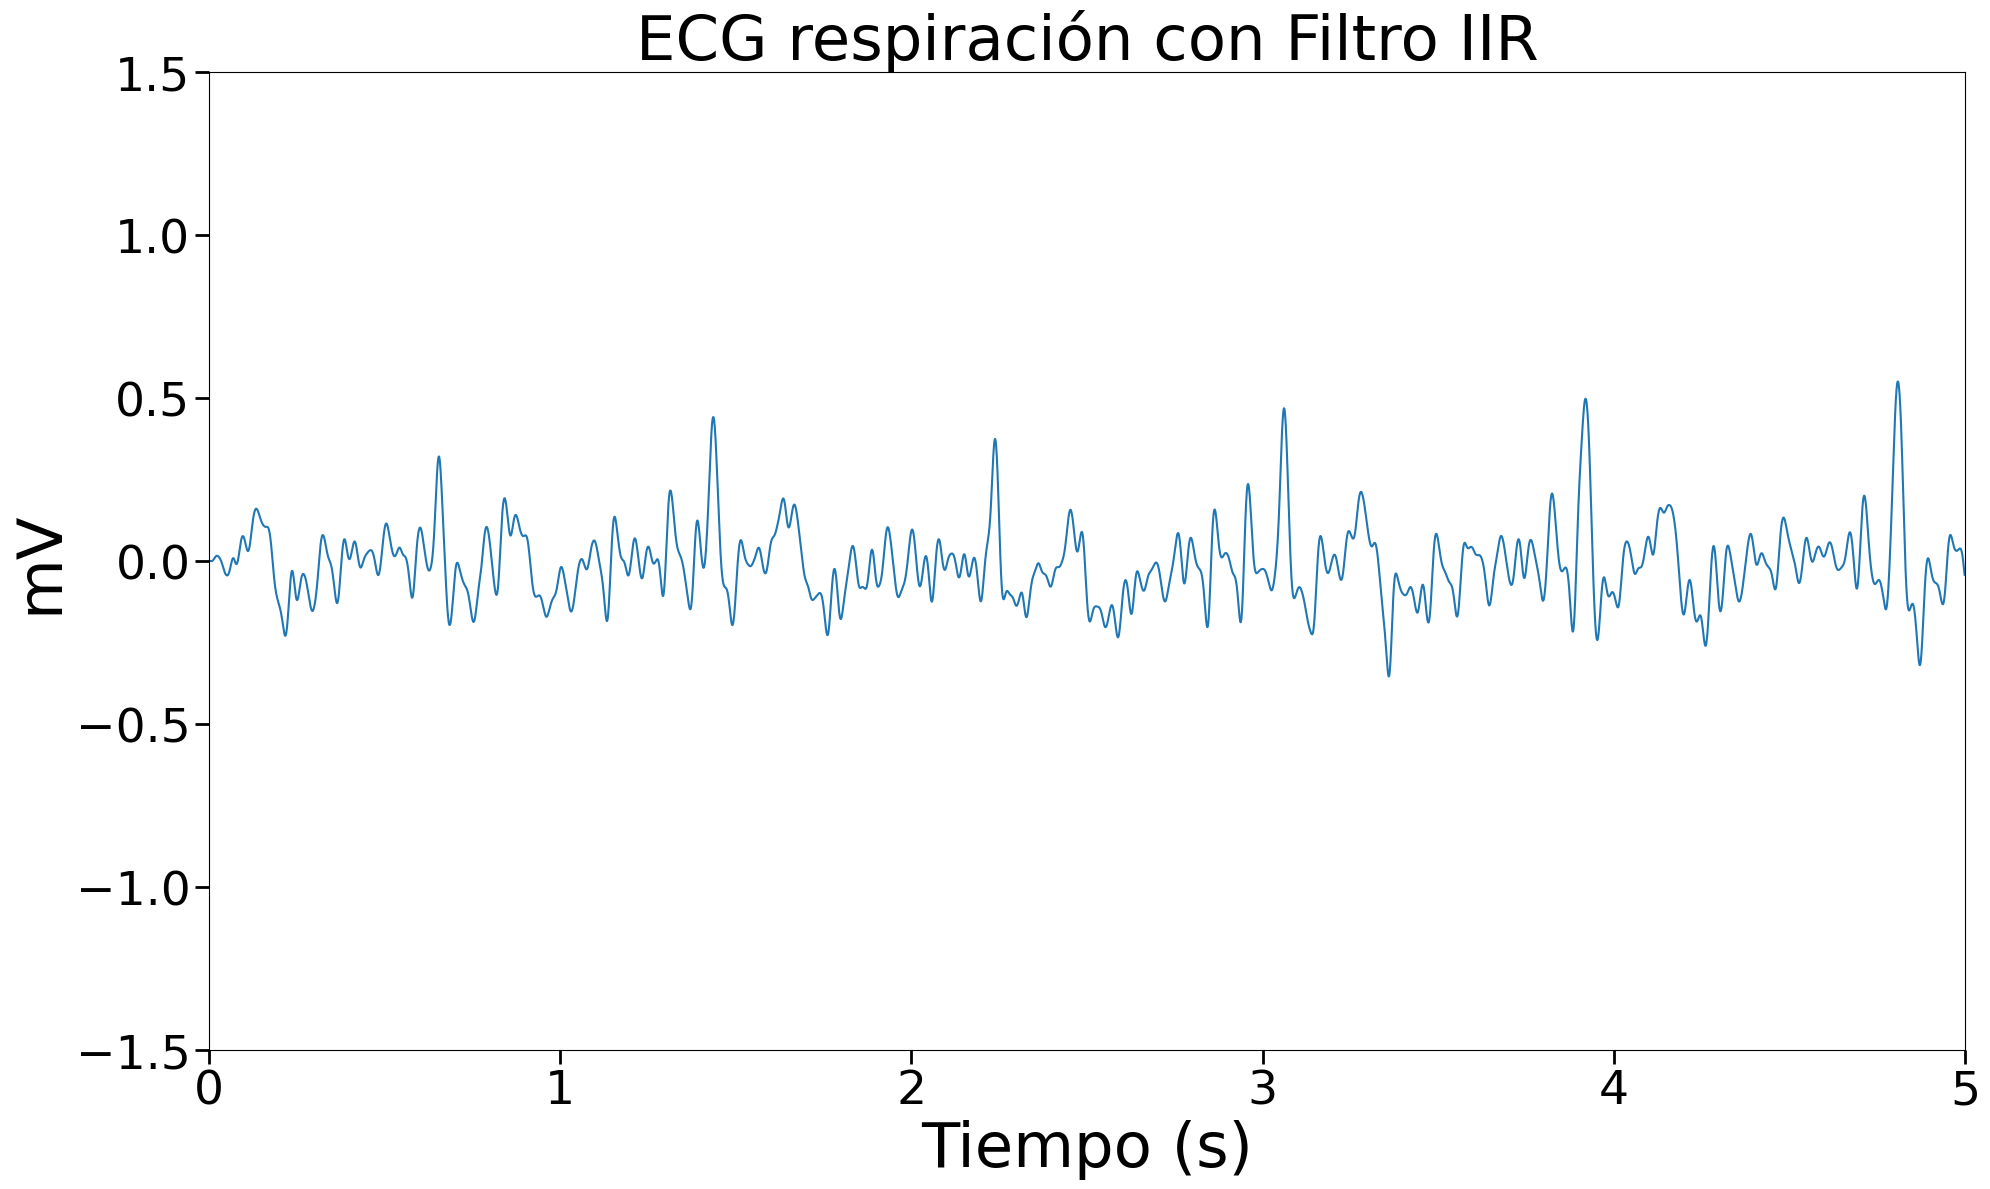

In [26]:
y = signal.lfilter(bd,ad, x)

#eje de tiempo en seg
Fs=1000 #frecuencia de muestreo
n=np.arange(len(x))
t = n/Fs

plt.figure(figsize=(20,12))

plt.plot(t,y)

plt.ylim(-1.5, 1.5)
plt.xlim(0, 5)
plt.tick_params(axis='both', which='major', labelsize=34, width=2, length=10)
plt.xlabel('Tiempo (s)', fontsize=45)
plt.ylabel('mV', fontsize=45)
plt.title('ECG respiración con Filtro IIR', fontsize=45)
plt.tight_layout()

plt.savefig("plots/ecg-respiracion-IIR.png")



# Ejercicio FIR

## Load data

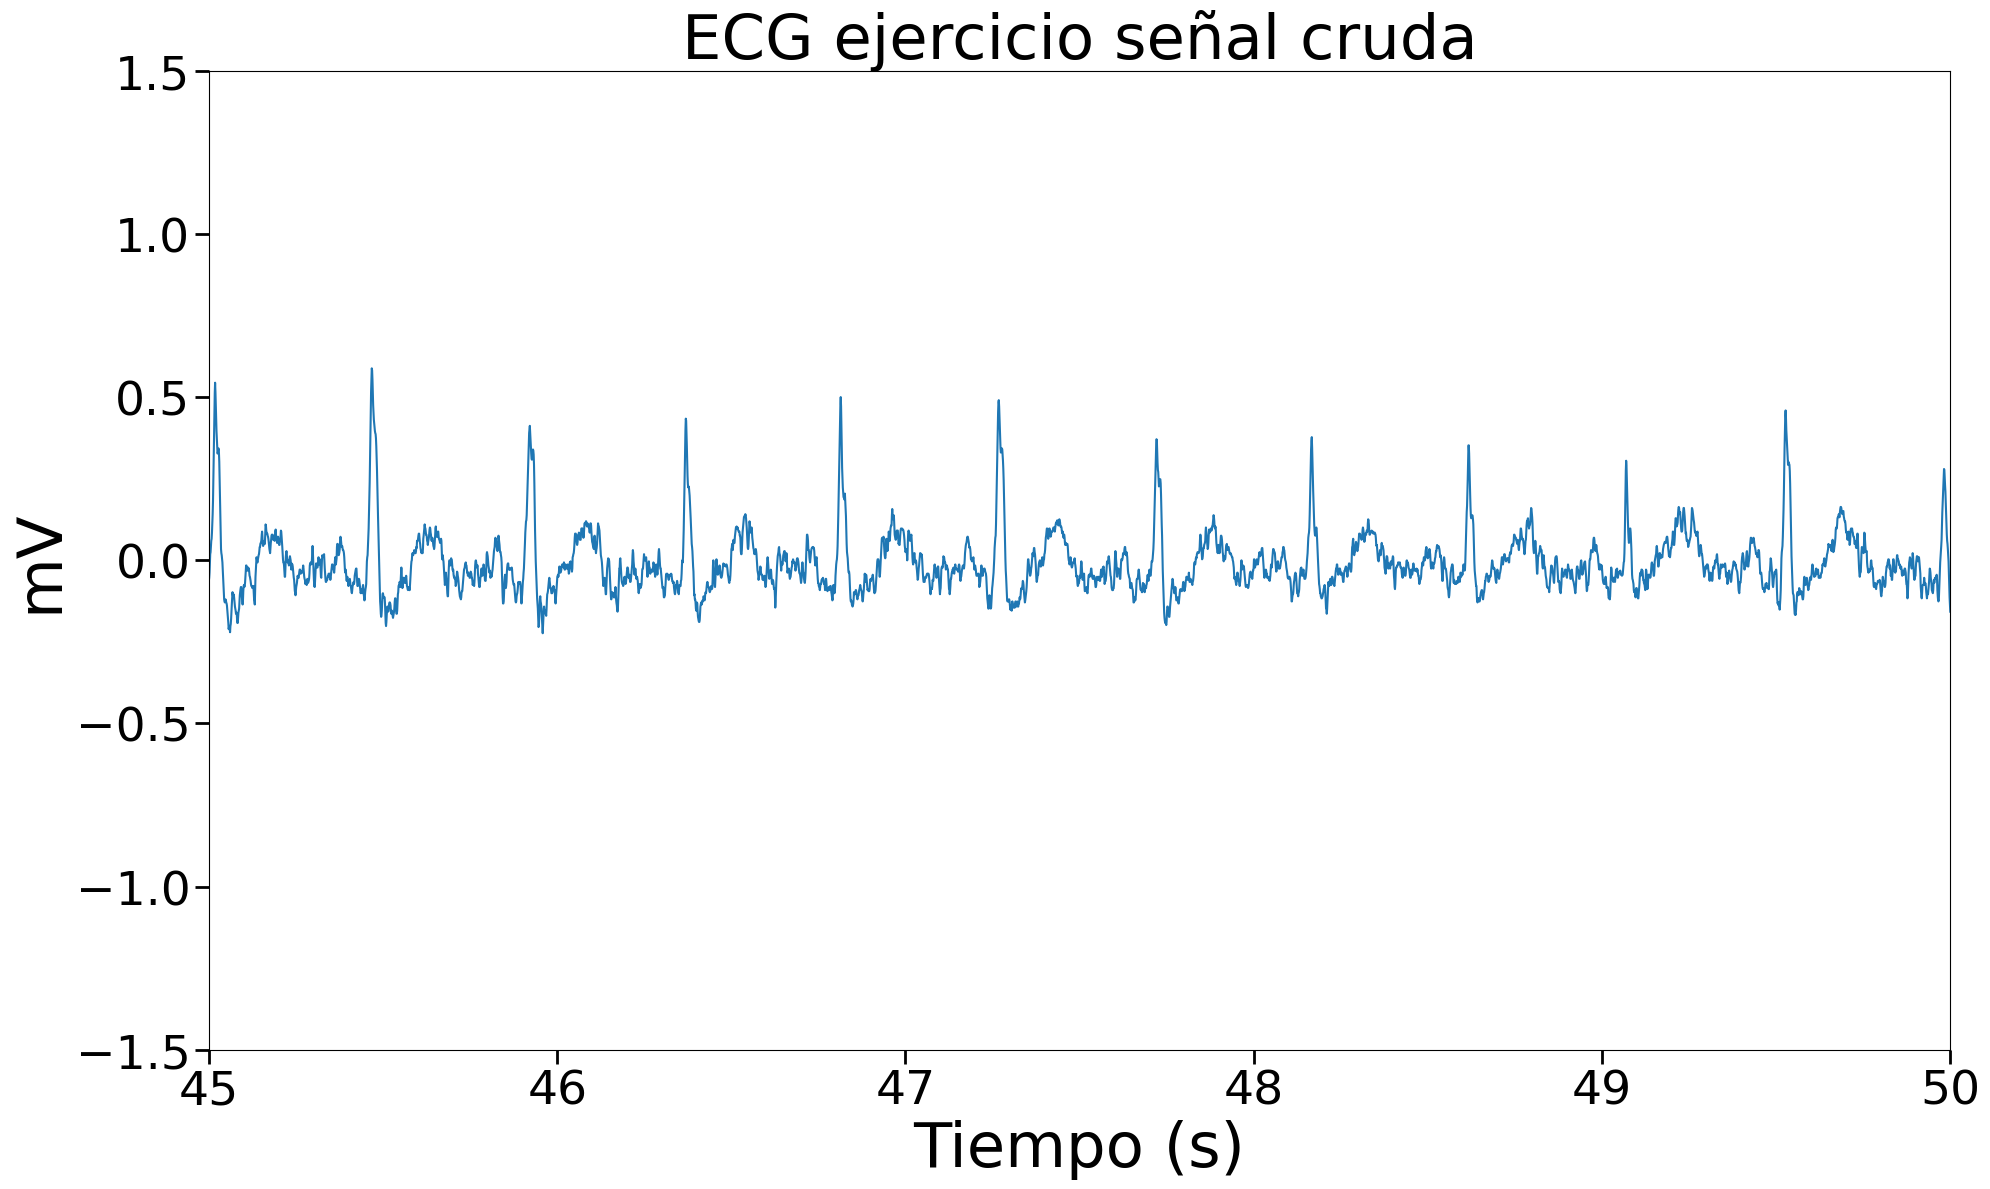

In [68]:
data=np.loadtxt("./../Laboratorio 4/ecg_raw_data/ejercicio/opensignals_98D341FD4F0D_2024-04-19_12-46-31.txt",skiprows=3)
data_mV = data[:,5]/1024 *3.223 - 3.223/2 #De acuerdo a la cuantización de 3.223 mV a 1024 bits del manual de Bitalino
time = np.arange(len(data_mV))/1000 
plt.figure(figsize=(20,12))

plt.plot(time,data_mV)

plt.ylim(-1.5, 1.5)
plt.xlim(45, 50)
plt.tick_params(axis='both', which='major', labelsize=34, width=2, length=10)
plt.xlabel('Tiempo (s)', fontsize=45)
plt.ylabel('mV', fontsize=45)
plt.title('ECG ejercicio señal cruda', fontsize=45)
plt.tight_layout()

plt.savefig("plots/ecg-ejercicio-cruda.png")


## DFT de N puntos

(1024,)


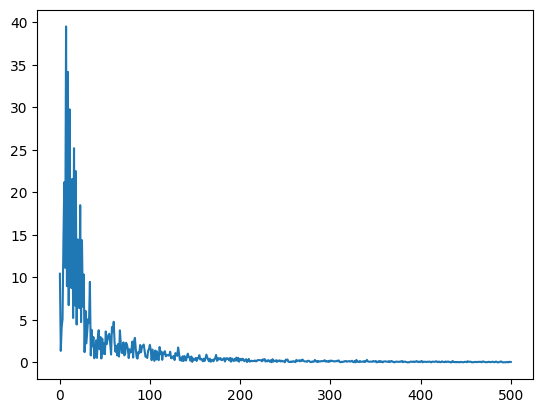

In [69]:
#Tomamos solo 5 segundos de la señal
x=data_mV[45000:50000]

#transformada de fourier FFT
Fs = 1000 #frecuencia de muestreo
N = 1024
X = np.fft.fft(x,N)
print(X.shape)

X = X[0:(N//2)]

#magnitud
Xm = np.abs(X)
Xm = np.round(Xm,3)

#frecuencias
F = np.linspace(0, Fs/2, N//2)

#eje de tiempo en seg
n=np.arange(len(x))
t = n/Fs

plt.plot(F,Xm)
#plt.xlim(0, 10)


## Diseñar el filtro FIR pasa bajos

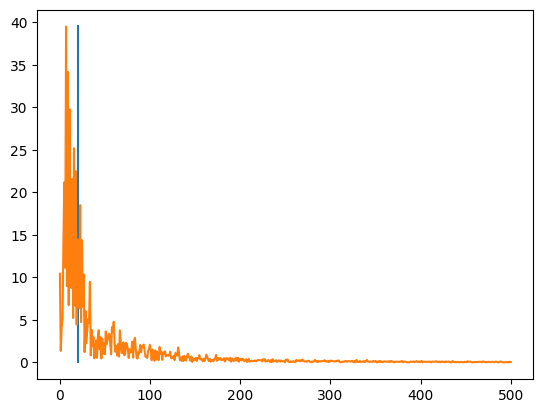

In [70]:
#longitud de la ventana
M = 37
#frecuencia de corte en Hz
Fc = 20
#Frecuencia de muestreo
Fs = 1000 #frecuencia de muestreo

#Frecuencia de corte en radianes
wc = 2*np.pi*Fc/Fs

# filtro fir
w = firwin(numtaps=M, cutoff=Fc, window='hamming', fs=Fs)
w = np.round(w,3)

nm = np.arange(M)
W = np.fft.fft(w,N)
W = np.round(W[0:N//2],3)

#magnitud
Wm = np.abs(W)
Rx = Fc*np.ones([N//2])
Ry = np.linspace(0,1,N//2)

Ry = np.linspace(0,np.max(Xm),N//2) #el eje y

plt.plot(Rx,Ry)
plt.plot(F,Xm)

## Aplicación del filtro FIR a la entrada x

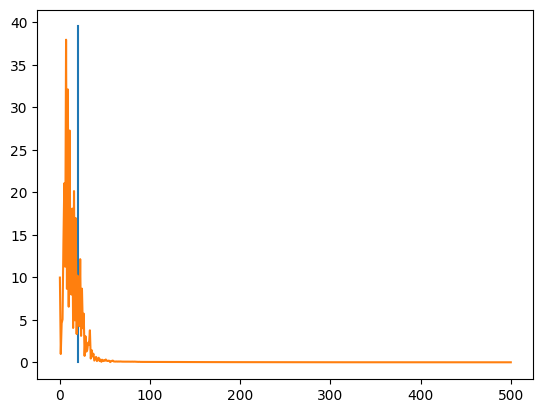

In [71]:
y = lfilter(w, np.array(1),x)
Y = np.fft.fft(y,N)
Y = np.round(Y[0:N//2],3)

Ym = np.abs(Y)

Ry = np.linspace(0,np.max(Xm),N//2) #el eje y

plt.plot(Rx,Ry)
plt.plot(F,Ym)


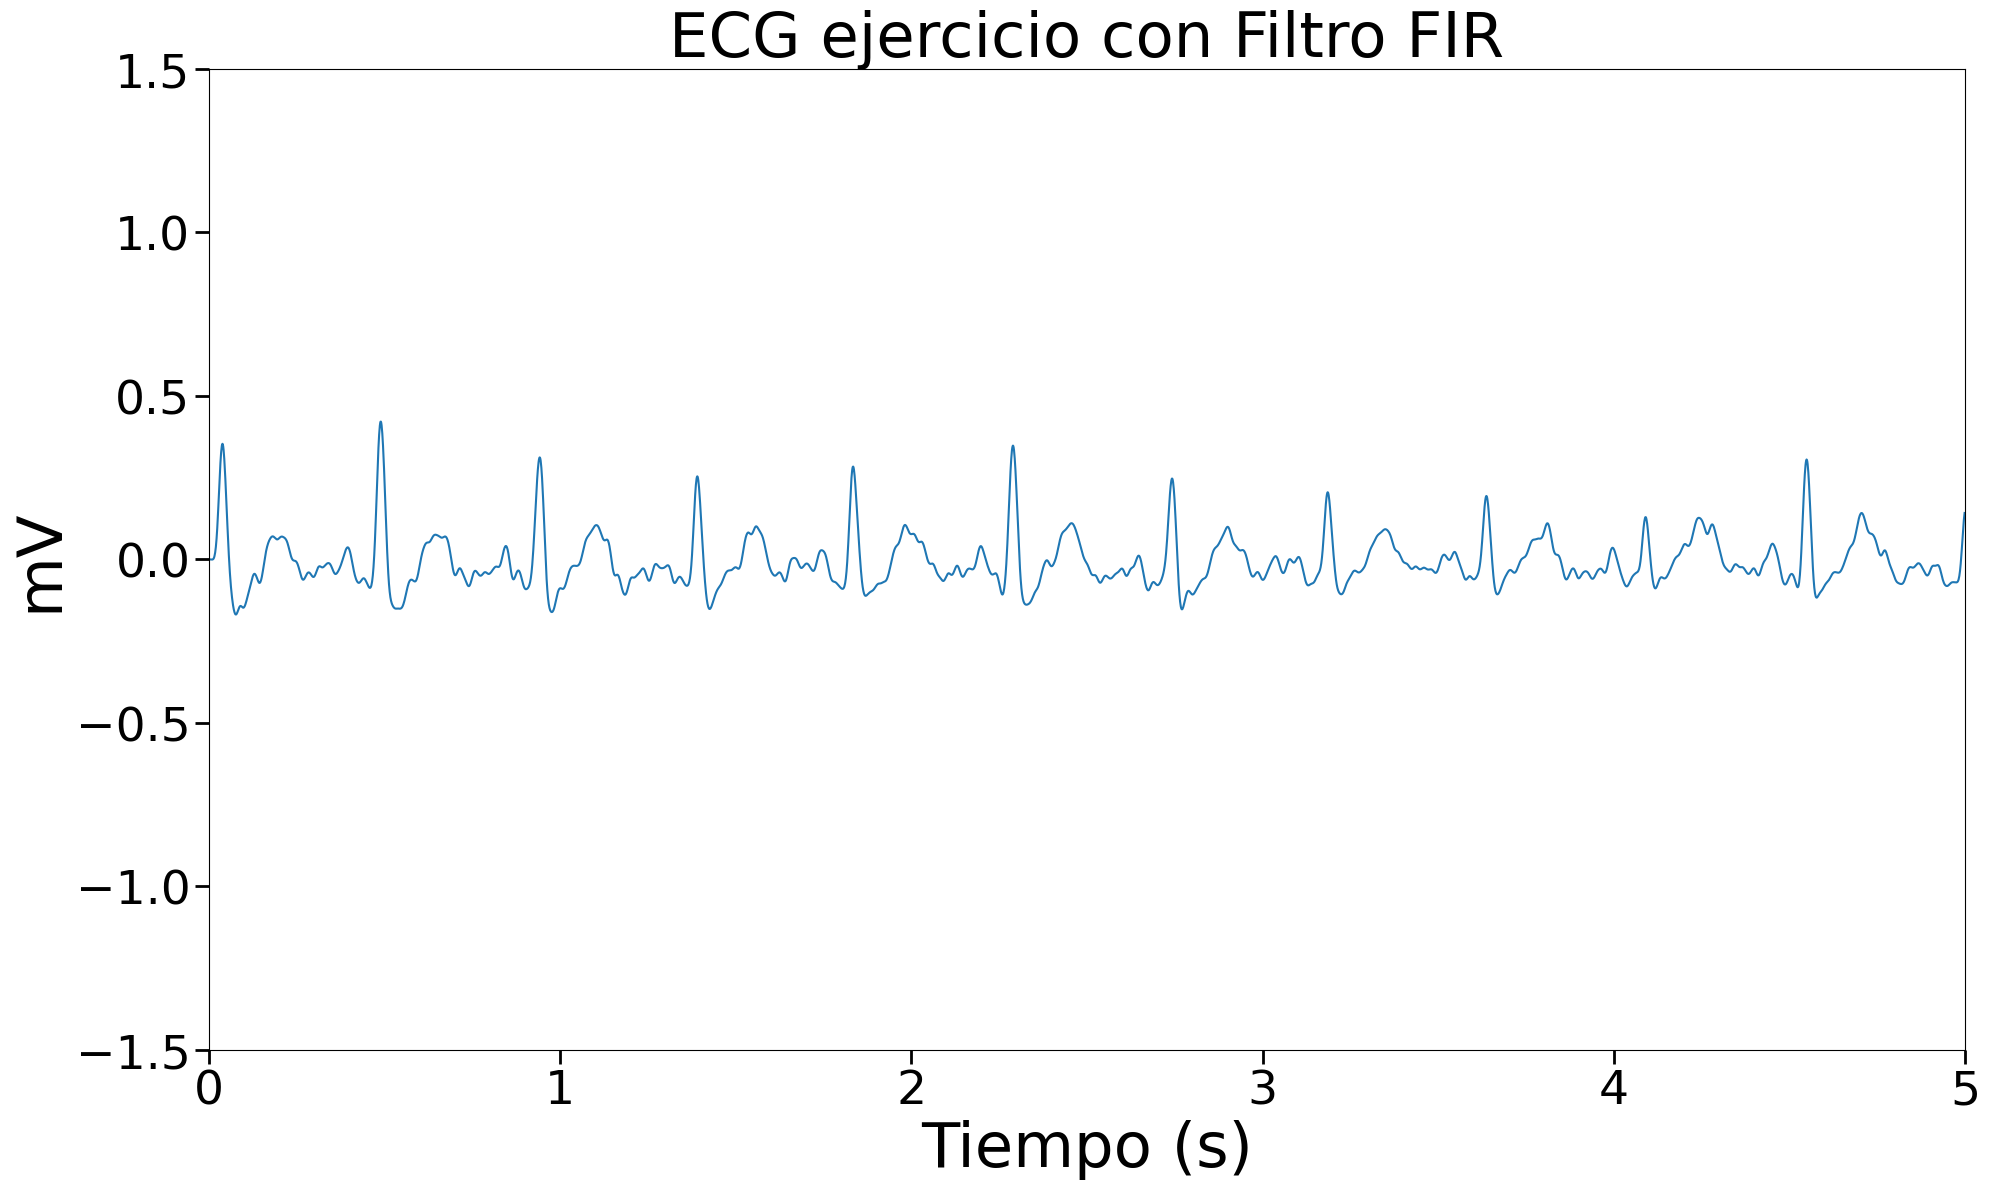

In [72]:
plt.figure(figsize=(20,12))

plt.plot(t,y)

plt.ylim(-1.5, 1.5)
plt.xlim(0, 5)
plt.tick_params(axis='both', which='major', labelsize=34, width=2, length=10)
plt.xlabel('Tiempo (s)', fontsize=45)
plt.ylabel('mV', fontsize=45)
plt.title('ECG ejercicio con Filtro FIR', fontsize=45)
plt.tight_layout()

plt.savefig("plots/ecg-ejercicio-FIR.png")
